#### ***1/-Setup and Library Imports***


First things first, let's get our environment ready by importing all the necessary libraries. This includes tools for handling data, Arabic text preprocessing (like NLTK and Camel Tools), machine learning algorithms, and performance evaluation metrics. We'll also handle any initial NLTK downloads and check for Camel Tools, which are super helpful for Arabic text.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from collections import defaultdict

# Download NLTK stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK stopwords already downloaded.")
except nltk.downloader.DownloadError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords', quiet=True)
    print("NLTK stopwords downloaded.")

from nltk.corpus import stopwords
from pyarabic.araby import strip_tashkeel
from nltk.stem.isri import ISRIStemmer

try:
    from camel_tools.tokenizers.word import simple_word_tokenize
    from camel_tools.morphology.database import MorphologyDB
    from camel_tools.morphology.analyzer import Analyzer
    print("Camel Tools components imported successfully.")
    _camel_db = MorphologyDB.builtin_db()
    _camel_analyzer = Analyzer(_camel_db)
except ImportError:
    print("Camel Tools not found. Please install it: pip install camel-tools")
    print("Then download resources: python -m camel_tools.utils.download default -q")
    simple_word_tokenize = None
    _camel_db = None
    _camel_analyzer = None
    print("Warning: Camel Tools functionality (tokenization, lemmatization) will be limited.")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE

# Removed from this version: from sklearn.feature_selection import SelectKBest, chi2

print("\n--- All Libraries Loaded/Checked ---")

NLTK stopwords already downloaded.
Camel Tools components imported successfully.

--- All Libraries Loaded/Checked ---


#### ***2/- Data Loading Exploratory Data Analysis (EDA)***

##### **>Load Dataset**


Now, let's load our dataset of Arabic tweets. We'll perform some initial Exploratory Data Analysis (EDA) to get a feel for the data. This means checking the total number of samples, seeing how many tweets fall into each sentiment category, and looking at basic text length statistics.

In [31]:
print("\n--- 2. Data Loading and Initial Exploration ---")
file_path = "./dataset/TextClasses/Tweets.txt" # Make sure this path is correct for your setup

data = []
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                text, label = line.rsplit('\t', 1)
                data.append((text.strip(), label.strip()))
            except ValueError:
                print(f"Line format error (skipped): {line}")
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check the path.")
    df = pd.DataFrame()
else:
    df = pd.DataFrame(data, columns=["text", "label"])

if not df.empty:
    print("\nDataset loaded successfully:")
    print(f"Total samples: {len(df)}")
    print("Labels distribution:\n", df['label'].value_counts())
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
else:
    print("Dataset is empty. Please check data loading steps and file path.")


--- 2. Data Loading and Initial Exploration ---

Dataset loaded successfully:
Total samples: 10006
Labels distribution:
 label
OBJ        6691
NEG        1684
NEUTRAL     832
POS         799
Name: count, dtype: int64

First 5 rows of the dataset:
                                                text    label
0  بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...      OBJ
1  أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...      POS
2  البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...      NEG
3  #الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...      OBJ
4  الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...  NEUTRAL

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10006 entries, 0 to 10005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10006 non-null  object
 1   label   10006 non-null  object
dtypes: object(2)
memory usage: 156.5+ KB


##### **> Exploratory Data Analysis (EDA) Visualizations**

Visualizing our data helps us understand its characteristics better. We'll create plots to show the distribution of sentiment classes, word counts, and character counts in the tweets. This helps us spot potential imbalances or patterns before we even start modeling.


--- Exploratory Data Analysis (EDA) Visualizations ---


C:\Users\hafia\AppData\Local\Temp\ipykernel_15700\843020386.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, order=df['label'].value_counts().index, palette="viridis")


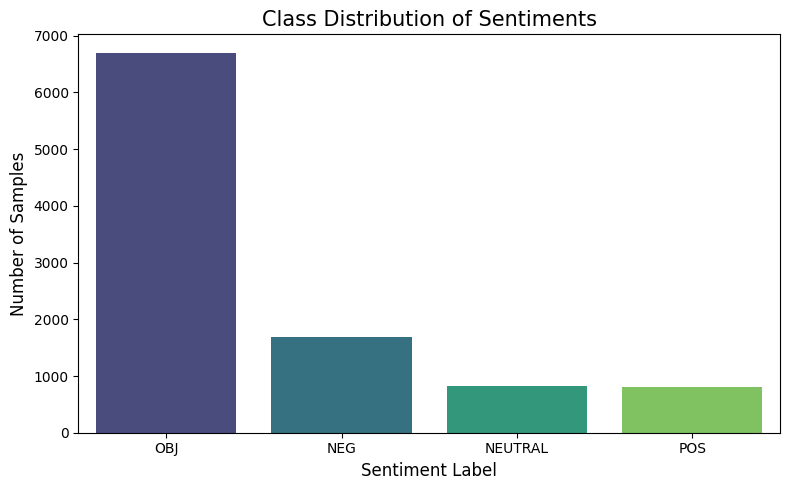


Descriptive statistics for text lengths (character count):
count    10006.000000
mean        83.633320
std         33.999717
min          4.000000
25%         57.000000
50%         86.000000
75%        111.000000
max        178.000000
Name: char_count, dtype: float64

Descriptive statistics for text lengths (word count):
count    10006.000000
mean        14.191885
std          6.174698
min          1.000000
25%          9.000000
50%         14.000000
75%         19.000000
max         32.000000
Name: word_count, dtype: float64


C:\Users\hafia\AppData\Local\Temp\ipykernel_15700\843020386.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=df, palette="pastel")


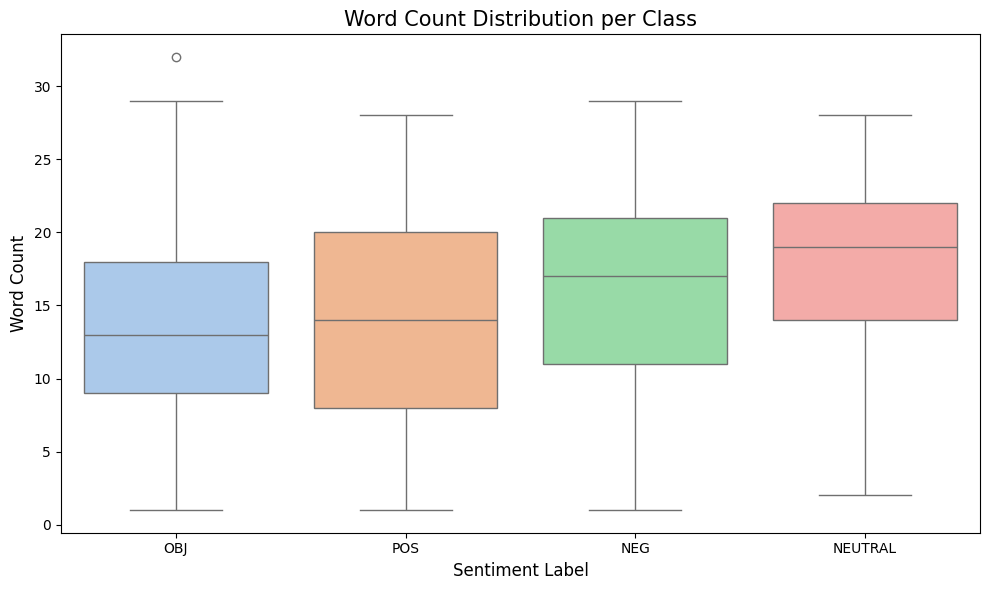

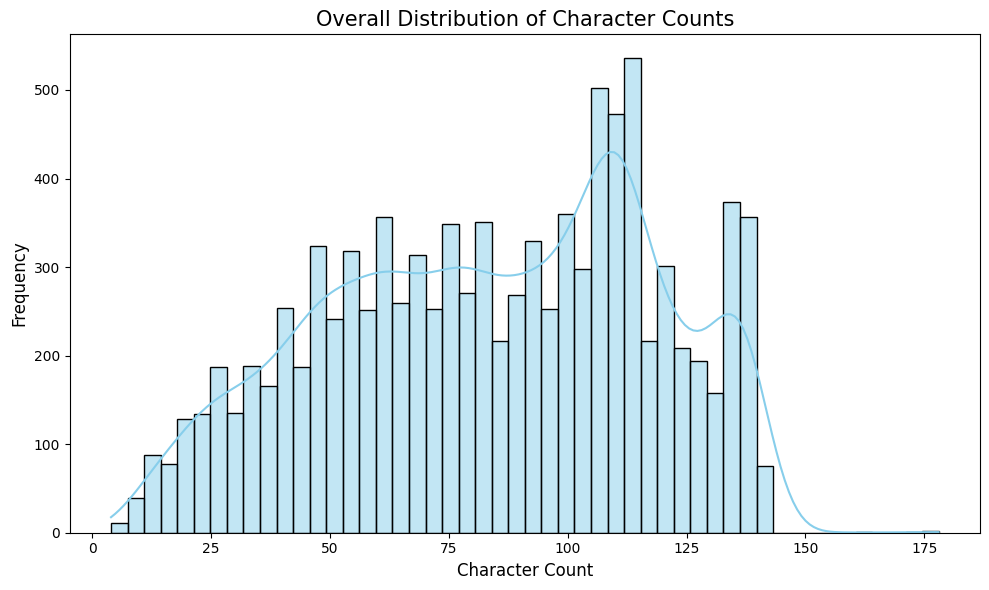

In [32]:
if not df.empty:
    print("\n--- Exploratory Data Analysis (EDA) Visualizations ---")

    # Class Distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=df, order=df['label'].value_counts().index, palette="viridis")
    plt.title('Class Distribution of Sentiments', fontsize=15)
    plt.xlabel('Sentiment Label', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Calculate word and character counts
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['char_count'] = df['text'].str.len()

    # Descriptive statistics for text lengths
    print("\nDescriptive statistics for text lengths (character count):")
    print(df['char_count'].describe())
    print("\nDescriptive statistics for text lengths (word count):")
    print(df['word_count'].describe())

    # Word Count Distribution per Class
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='word_count', data=df, palette="pastel")
    plt.title('Word Count Distribution per Class', fontsize=15)
    plt.xlabel('Sentiment Label', fontsize=12)
    plt.ylabel('Word Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Overall Distribution of Character Counts
    plt.figure(figsize=(10, 6))
    sns.histplot(df['char_count'], bins=50, kde=True, color='skyblue')
    plt.title('Overall Distribution of Character Counts', fontsize=15)
    plt.xlabel('Character Count', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty, skipping EDA visualizations.")

#### ***3/- Data Splitting and Evaluation Helper Functions***

Before we start training, we need to split our dataset into training and testing sets. We'll use a stratified split to ensure that the proportion of each sentiment class is maintained in both sets, which is vital for imbalanced datasets. We'll also define a helper function evaluate_model to consistently report our model's performance using Accuracy, Macro F1-score, Weighted F1-score, a detailed classification report, and a confusion matrix.

In [33]:
# --- Data Splitting ---
if not df.empty:
    print("\n--- 4. Data Splitting ---")
    X = df['text']
    y = df['label']

    # Stratified split to maintain class distribution in train and test sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Train set total samples: {len(y_train)}")
    print("Train set class distribution:\n", y_train.value_counts())
    print(f"\nTest set total samples: {len(y_test)}")
    print("Test set class distribution:\n", y_test.value_counts())
else:
    print("DataFrame is empty, skipping data splitting.")

# --- Model Evaluation Function ---
def evaluate_model(model, X_test_vec, y_test_true, model_name="Model", show_cm=True, print_classification_report=True):
    """
    Evaluates the given model and prints accuracy, macro F1-score, weighted F1-score,
    and optionally plots the confusion matrix and prints a detailed classification report.
    Returns both macro and weighted F1-scores.
    """
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test_true, y_pred)
    macro_f1 = f1_score(y_test_true, y_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_test_true, y_pred, average='weighted', zero_division=0)

    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")

    if print_classification_report:
        print("\nClassification Report:\n", classification_report(y_test_true, y_pred, zero_division=0))

    if show_cm:
        cm_labels = model.classes_ if hasattr(model, 'classes_') else sorted(y_test_true.unique())
        cm = confusion_matrix(y_test_true, y_pred, labels=cm_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
        plt.title(f'Confusion Matrix for {model_name}', fontsize=15)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()

    return macro_f1, weighted_f1

print("\nEvaluation function defined.")


--- 4. Data Splitting ---
Train set total samples: 8004
Train set class distribution:
 label
OBJ        5352
NEG        1347
NEUTRAL     666
POS         639
Name: count, dtype: int64

Test set total samples: 2002
Test set class distribution:
 label
OBJ        1339
NEG         337
NEUTRAL     166
POS         160
Name: count, dtype: int64

Evaluation function defined.


#### ***/4-Arabic Text Preprocessing Pipeline***

This is where we define the brains of our text preparation. We have a function to normalize Arabic text while being mindful of sentiment-rich elements like emojis. Then, our preprocess_arabic_pipeline function takes text and applies different levels of cleaning:

- light: Basic normalization and tokenization.
- moderate: Adds stopword removal.
- lemmatize: Uses Camel Tools for word lemmatization (reducing words to their base form).
- stem: Employs ISRIStemmer for aggressive word stemming.

In [34]:
print("\n--- 5. Flexible Arabic Text Preprocessing Functions ---")

arabic_stopwords_list = set(stopwords.words('arabic'))
isri_stemmer = ISRIStemmer()

def normalize_arabic_text_sentiment_aware(text, keep_emojis=True, keep_numbers=False, keep_some_punct=True):
    """
    Performs Arabic text normalization with options to keep elements
    often crucial for sentiment analysis (emojis, numbers, some punctuation).
    """
    # 1. Remove URLs, Mentions, Hashtag symbols (keep hashtag text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text) # Remove only the '#' symbol

    # 2. Remove diacritics (tashkeel)
    text = strip_tashkeel(text)

    # 3. Normalize common Arabic character variants (as per research recommendations)
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # 4. Remove elongations (e.g., "جمييييل" -> "جميل"). Keep at most 3 repetitions.
    text = re.sub(r'(.)\1{3,}', r'\1\1', text)

    # 5. Remove Kasheeda/Tatweel (ـ)
    text = re.sub(r'ـ+', '', text)

    # 6. Handle non-Arabic characters, punctuation, and numbers flexibly
    if keep_emojis:
        # Unicode ranges for Arabic, Latin (for numbers/basic punct), and common emoji blocks
        text = re.sub(r'[^\u0600-\u06FF\s\d\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\?\!,\.]', ' ', text)
    else:
        pattern = r'[^\u0600-\u06FF\s\?\!,\.]'
        if keep_numbers:
            pattern = r'[^\u0600-\u06FF\s\d\?\!,\.]'
        text = re.sub(pattern, ' ', text)

    # 7. Remove extra spaces and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_arabic_pipeline(text, level='light'):
    """
    Applies different levels of preprocessing based on the 'level' parameter.
    'light': Normalization (sentiment-aware), Tokenization. No stopwords, no stemming/lemmatization.
    'moderate': light + Stopword Removal.
    'lemmatize': moderate + Lemmatization (using Camel Tools).
    'stem': moderate + Stemming (using ISRIStemmer).
    """
    normalized_text = normalize_arabic_text_sentiment_aware(text, keep_emojis=True, keep_numbers=False, keep_some_punct=True)

    if simple_word_tokenize:
        tokens = simple_word_tokenize(normalized_text)
    else:
        tokens = normalized_text.split()

    tokens = [token for token in tokens if len(token) > 1] # Remove very short tokens

    if level == 'light':
        return ' '.join(tokens)

    filtered_tokens = [token for token in tokens if token not in arabic_stopwords_list]

    if level == 'moderate':
        return ' '.join(filtered_tokens)
    elif level == 'lemmatize':
        if _camel_analyzer:
            processed_tokens = []
            for token in filtered_tokens:
                analyses = _camel_analyzer.analyze(token)
                if analyses:
                    lemma = analyses[0].get('lemma', token)
                    processed_tokens.append(lemma)
                else:
                    processed_tokens.append(token)
            return ' '.join(processed_tokens)
        else:
            print("Warning: Camel Tools Analyzer not available for lemmatization. Falling back to 'moderate' level.")
            return ' '.join(filtered_tokens)
    elif level == 'stem':
        processed_tokens = [isri_stemmer.stem(token) for token in filtered_tokens]
        return ' '.join(processed_tokens)
    else:
        raise ValueError(f"Unknown preprocessing level: {level}")

print("Flexible preprocessing functions defined.")


--- 5. Flexible Arabic Text Preprocessing Functions ---
Flexible preprocessing functions defined.


#### ***5/-Building Machine learning Models***

Here, we define the machine learning models we want to test and their hyperparameter grids for GridSearchCV. We're including common text classification models like **Logistic Regression**, **LinearSVC**, **SGDClassifier**, and **Multinomial Naive Bayes**.

In [35]:
# --- 6. Model Configuration ---

models_to_tune = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.1, 1, 10, 50],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
    },
    'LinearSVC': {
        'model': LinearSVC(max_iter=2000, random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.1, 1, 10, 50],
            'loss': ['hinge', 'squared_hinge']
        }
    },
    'SGDClassifier (LinearSVC-like)': {
        'model': SGDClassifier(max_iter=2000, random_state=42, class_weight='balanced'),
        'params': {
            'loss': ['hinge', 'log_loss'],
            'alpha': [0.00001, 0.0001, 0.001],
            'penalty': ['l2', 'l1']
        }
    },
    'MultinomialNB': { # MultinomialNB does not support class_weight directly, rely on resampling
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
        }
    }
}

print("Model configurations defined.")

Model configurations defined.


#### ***6/-Training and Evaluation Function***


This function is the workhorse of our ablation study. For a given preprocessing level and set of models, it handles the entire pipeline:

- TF-IDF Vectorization: Converts text into numerical features.
- Feature Selection: Uses SelectKBest to pick the most relevant features based on the Chi-squared test.
- SMOTE Oversampling: Addresses class imbalance by creating synthetic samples for minority classes.
- GridSearchCV: Tunes the model's hyperparameters, optimizing for Weighted F1-score.
- Evaluation: Assesses the model's performance on the test set.

In [36]:
# --- 7. Training and Evaluation Function ---

def train_and_evaluate_config(pp_level_name, X_train_pp, X_test_pp, y_train, y_test, models_to_tune):
    """
    Handles TF-IDF, SMOTE, GridSearchCV, and evaluation for a given
    preprocessing level and set of models.
    Returns a dictionary of results for this preprocessing level.
    """
    results_for_level = {}

    print(f"\n\n--- Starting Processing for Level: {pp_level_name.upper()} ---")

    # --- TF-IDF Vectorization ---
    # Adjust max_features based on the preprocessing level
    current_max_features = 12000 if pp_level_name in ['light', 'moderate', 'Baseline - Raw Text'] else 8000
    vectorizer = TfidfVectorizer(
        max_features=current_max_features,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9
    )
    X_train_tfidf = vectorizer.fit_transform(X_train_pp)
    X_test_tfidf = vectorizer.transform(X_test_pp)

    print(f"TF-IDF Vocab size: {len(vectorizer.get_feature_names_out())}")
    print(f"Shape of TF-IDF for training data: {X_train_tfidf.shape}")

    # --- Oversampling (SMOTE) ---
    smote_final = SMOTE(random_state=42, k_neighbors=3)
    X_train_balanced, y_train_balanced = smote_final.fit_resample(X_train_tfidf, y_train)
    print(f"Shape of X_train after SMOTE: {X_train_balanced.shape}")
    print("Class distribution after SMOTE:\n", pd.Series(y_train_balanced).value_counts())

    # Store components needed to re-evaluate the best model later
    results_for_level['vectorizer'] = vectorizer
    results_for_level['X_test_transformed'] = X_test_tfidf # Store pre-transformed test data

    # --- Model Tuning and Evaluation ---
    for model_name, config in models_to_tune.items():
        print(f"\n--- Tuning {model_name} ---")
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=5,
            scoring='f1_weighted', # Optimize for weighted F1-score
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train_balanced, y_train_balanced)

        best_model = grid_search.best_estimator_
        macro_f1, weighted_f1 = evaluate_model(
            best_model, X_test_tfidf, y_test, # Use X_test_tfidf as no feature selection is applied
            f"{model_name} Tuned", show_cm=False, print_classification_report=False # Suppress detailed output for intermediate runs
        )
        results_for_level[model_name] = {
            'macro_f1': macro_f1,
            'weighted_f1': weighted_f1,
            'best_params': grid_search.best_params_,
            'best_estimator': best_model # Store the actual best model object
        }
        print(f"Best params: {grid_search.best_params_}, CV Weighted F1: {grid_search.best_score_:.4f}")
    
    return results_for_level

#### ***7/-Running the Ablation Study***

This is where we execute our train_and_evaluate_config function for each preprocessing level, including the baseline (raw text). This process might take some time as it involves multiple steps of preprocessing, feature selection, oversampling, and hyperparameter tuning for each model.

In [37]:
# --- 8. Running the Ablation Study ---
preprocessed_data_splits = {} # Stores (X_train_pp, X_test_pp) for each level
all_ablation_results = {} # Stores detailed results for all configs

if not df.empty and 'X_train_raw' in locals():
    # --- Apply Different Levels of Preprocessing ---
    print("\n--- Applying Different Levels of Preprocessing to Data ---")
    preprocessing_levels_to_test = [
        'light',
        'moderate',
        'lemmatize',
        'stem'
    ]

    for level in preprocessing_levels_to_test:
        print(f"Preprocessing text for level: '{level}'...")
        X_train_pp = X_train_raw.apply(lambda x: preprocess_arabic_pipeline(x, level=level))
        X_test_pp = X_test_raw.apply(lambda x: preprocess_arabic_pipeline(x, level=level))
        preprocessed_data_splits[level] = (X_train_pp, X_test_pp)

        print(f"  Sample original text: '{X_train_raw.iloc[0]}'")
        print(f"  Sample '{level}' text: '{X_train_pp.iloc[0]}'")
    print("\nAll preprocessing levels applied.")

    # --- Run Baseline (Raw Text) ---
    print("\n===== Running Baseline (Raw Text) Configuration =====")
    
    # Raw text is considered its own "preprocessing level" for the ablation study
    baseline_X_train_pp = X_train_raw
    baseline_X_test_pp = X_test_raw
    
    # Store results for the baseline configuration
    all_ablation_results["Baseline - Raw Text"] = train_and_evaluate_config(
        "Baseline - Raw Text", baseline_X_train_pp, baseline_X_test_pp, y_train, y_test, models_to_tune
    )

    # --- Run for each Preprocessing Level defined ---
    for pp_level_name, (X_train_pp, X_test_pp) in preprocessed_data_splits.items():
        all_ablation_results[pp_level_name] = train_and_evaluate_config(
            pp_level_name, X_train_pp, X_test_pp, y_train, y_test, models_to_tune
        )

else:
    print("DataFrame or raw split data is empty. Skipping main training and evaluation loop.")


--- Applying Different Levels of Preprocessing to Data ---
Preprocessing text for level: 'light'...
  Sample original text: 'عرض الاسبوع 44 ألف متابع #أذكار_المساء #بصراحه_مليت_من #خد_موقف_من #علمتني_الحياة #الحياة_تحتاج_إلى_شيئين [935531]'
  Sample 'light' text: 'عرض الاسبوع 44 الف متابع اذكار المساء بصراحه مليت من خد موقف من علمتني الحياه الحياه تحتاج الي شييين 935531'
Preprocessing text for level: 'moderate'...
  Sample original text: 'عرض الاسبوع 44 ألف متابع #أذكار_المساء #بصراحه_مليت_من #خد_موقف_من #علمتني_الحياة #الحياة_تحتاج_إلى_شيئين [935531]'
  Sample 'moderate' text: 'عرض الاسبوع 44 الف متابع اذكار المساء بصراحه مليت خد موقف علمتني الحياه الحياه تحتاج الي شييين 935531'
Preprocessing text for level: 'lemmatize'...
  Sample original text: 'عرض الاسبوع 44 ألف متابع #أذكار_المساء #بصراحه_مليت_من #خد_موقف_من #علمتني_الحياة #الحياة_تحتاج_إلى_شيئين [935531]'
  Sample 'lemmatize' text: 'عرض الاسبوع 44 الف متابع اذكار المساء بصراحه مليت خد موقف علمتني الحياه الحياه تحتاج الي شييين 9

#### ***8/-Final Summary of Results***

Now, let's look at the big picture! We'll collect all the F1 scores from our ablation study and present them clearly. We'll show results sorted by both Macro F1-score (which treats all classes equally) and Weighted F1-score (which accounts for class imbalance). This helps us see which combinations perform best overall.

In [38]:
# --- 9. Final Summary of Ablation Study Results ---
print("\n\n--- 9. Final Summary of F1 Scores (Ablation Study) ---")

# Store results as a list of dictionaries for easier access
detailed_results_list = [] # Renamed to avoid conflict if cell is re-run without re-running previous

# Iterate through the collected results to populate our flat lists
for pp_level, results_data in all_ablation_results.items():
    for model_name, model_info in results_data.items():
        # Only process entries that are actual model results (i.e., contain 'macro_f1')
        if isinstance(model_info, dict) and 'macro_f1' in model_info:
            macro_f1 = model_info['macro_f1']
            weighted_f1 = model_info['weighted_f1']
            full_name = f"{model_name} ({pp_level})"
            detailed_results_list.append({
                'full_name': full_name,
                'macro_f1': macro_f1,
                'weighted_f1': weighted_f1,
                'model_name': model_name, # Store the original model_name key
                'pp_level': pp_level      # Store the original pp_level key
            })

if not detailed_results_list:
    print("No model performance results found to summarize.")
else:
    print("\n--- Sorted by Macro F1-score ---")
    sorted_by_macro = sorted(detailed_results_list, key=lambda item: item['macro_f1'], reverse=True)
    for item in sorted_by_macro:
        print(f"{item['full_name']}: Macro F1: {item['macro_f1']:.4f}")

    print("\n--- Sorted by Weighted F1-score ---")
    sorted_by_weighted = sorted(detailed_results_list, key=lambda item: item['weighted_f1'], reverse=True)
    for item in sorted_by_weighted:
        print(f"{item['full_name']}: Weighted F1: {item['weighted_f1']:.4f}")



--- 9. Final Summary of F1 Scores (Ablation Study) ---

--- Sorted by Macro F1-score ---
MultinomialNB (stem): Macro F1: 0.3955
LogisticRegression (stem): Macro F1: 0.3951
SGDClassifier (LinearSVC-like) (stem): Macro F1: 0.3916
LogisticRegression (light): Macro F1: 0.3873
LinearSVC (light): Macro F1: 0.3853
MultinomialNB (Baseline - Raw Text): Macro F1: 0.3790
SGDClassifier (LinearSVC-like) (lemmatize): Macro F1: 0.3785
SGDClassifier (LinearSVC-like) (moderate): Macro F1: 0.3785
LinearSVC (stem): Macro F1: 0.3774
SGDClassifier (LinearSVC-like) (light): Macro F1: 0.3760
LogisticRegression (moderate): Macro F1: 0.3753
SGDClassifier (LinearSVC-like) (Baseline - Raw Text): Macro F1: 0.3740
MultinomialNB (light): Macro F1: 0.3725
LogisticRegression (lemmatize): Macro F1: 0.3714
LogisticRegression (Baseline - Raw Text): Macro F1: 0.3698
LinearSVC (moderate): Macro F1: 0.3696
LinearSVC (lemmatize): Macro F1: 0.3684
MultinomialNB (moderate): Macro F1: 0.3666
MultinomialNB (lemmatize): Macro 

#### ***9/-Visualize Ablation Study Results***

Visualizing the F1 scores makes it much easier to compare the performance of different preprocessing and model combinations at a glance. We'll create bar plots for both Macro and Weighted F1 scores.

C:\Users\hafia\AppData\Local\Temp\ipykernel_15700\453748056.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='macro_f1', y='full_name', data=df_macro_plot, palette='coolwarm')


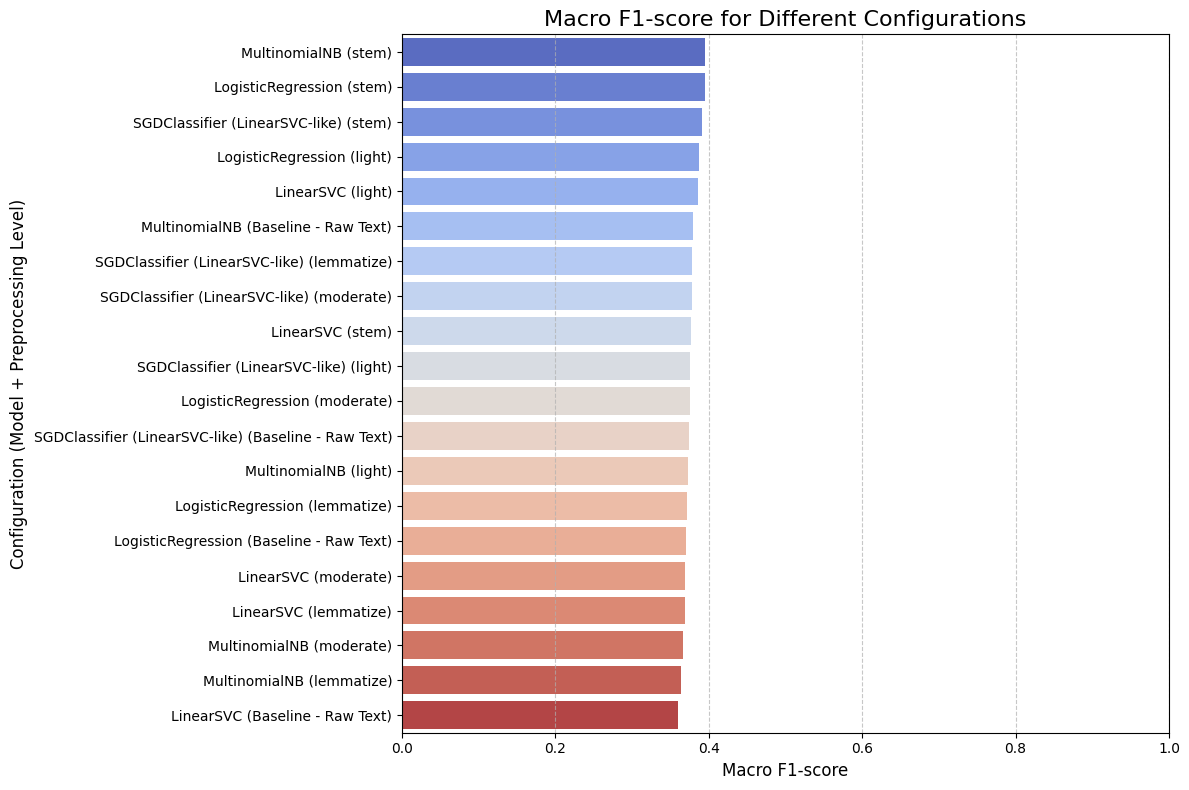

C:\Users\hafia\AppData\Local\Temp\ipykernel_15700\453748056.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_f1', y='full_name', data=df_weighted_plot, palette='magma')


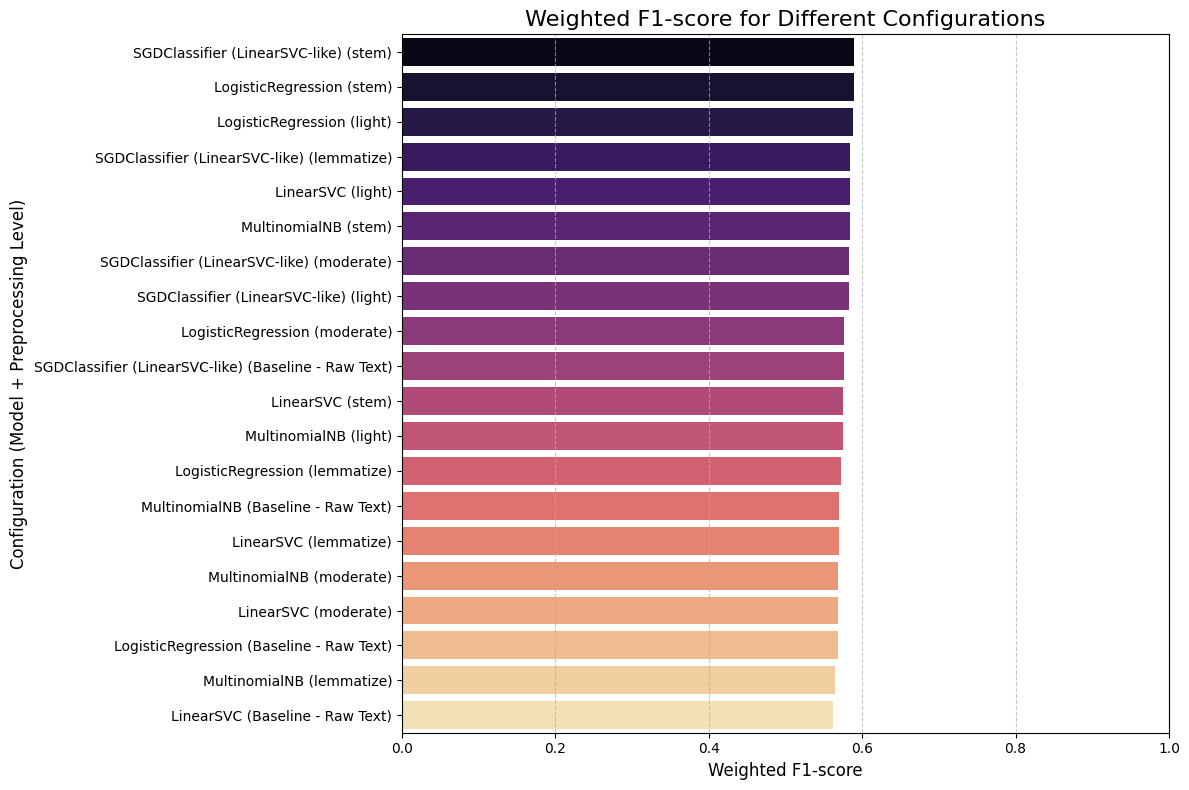

In [39]:
# --- 10. Visualize Ablation Study Results ---
# Ensure sorted_by_weighted and sorted_by_macro are available 
if ('sorted_by_weighted' in locals() and sorted_by_weighted) and \
   ('sorted_by_macro' in locals() and sorted_by_macro):

    # Prepare data for plotting
    # DataFrame will have columns based on the dictionary keys: 
    # 'full_name', 'macro_f1', 'weighted_f1', 'model_name', 'pp_level'
    df_macro_plot = pd.DataFrame(sorted_by_macro)
    df_weighted_plot = pd.DataFrame(sorted_by_weighted)

    # Plot Macro F1-scores
    plt.figure(figsize=(12, 8))
    # Use the dictionary keys for x and y parameters
    sns.barplot(x='macro_f1', y='full_name', data=df_macro_plot, palette='coolwarm')
    plt.title('Macro F1-score for Different Configurations', fontsize=16)
    plt.xlabel('Macro F1-score', fontsize=12)
    plt.ylabel('Configuration (Model + Preprocessing Level)', fontsize=12)
    plt.xlim(0, 1.0) # F1 scores are between 0 and 1
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot Weighted F1-scores
    plt.figure(figsize=(12, 8))
    # Use the dictionary keys for x and y parameters
    sns.barplot(x='weighted_f1', y='full_name', data=df_weighted_plot, palette='magma')
    plt.title('Weighted F1-score for Different Configurations', fontsize=16)
    plt.xlabel('Weighted F1-score', fontsize=12)
    plt.ylabel('Configuration (Model + Preprocessing Level)', fontsize=12)
    plt.xlim(0, 1.0) # F1 scores are between 0 and 1
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot.")

#### ***10/-Detailed Analysis of the Overall Best Model***

After seeing all the results, we'll pinpoint the single best-performing configuration based on its Weighted F1-score (as it's often more representative for imbalanced data). Then, we'll provide a full, detailed classification report and a confusion matrix for this top model. This gives us the deepest insight into how well it performs on each individual sentiment class.


--- Overall Best Performing Configuration (Based on Weighted F1): SGDClassifier (LinearSVC-like) (stem) with Weighted F1-score: 0.5893 ---

--- Detailed Classification Report and Confusion Matrix for the Overall Best Model (SGDClassifier (LinearSVC-like) (stem)) ---

--- Overall Best Model: SGDClassifier (LinearSVC-like) (stem) Evaluation ---
Accuracy: 0.5739
Macro F1-score: 0.3916
Weighted F1-score: 0.5893

Classification Report:
               precision    recall  f1-score   support

         NEG       0.35      0.41      0.38       337
     NEUTRAL       0.16      0.19      0.17       166
         OBJ       0.77      0.69      0.73      1339
         POS       0.25      0.33      0.28       160

    accuracy                           0.57      2002
   macro avg       0.38      0.41      0.39      2002
weighted avg       0.61      0.57      0.59      2002



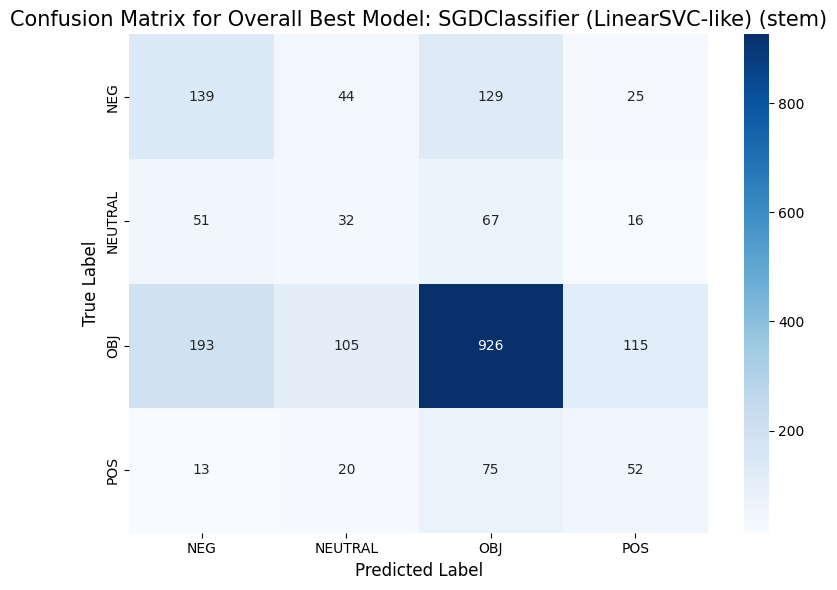

In [40]:
# --- 11. Detailed Analysis of the Overall Best Model ---

# Ensure detailed_results_list is populated and sorted from the previous cell's execution.
# Or, if running this cell independently, re-populate and sort it first.
# For this example, we'll assume `sorted_by_weighted` is available from cell 25.
# If not, you'd need to re-generate `detailed_results_list` and sort it here.

if 'sorted_by_weighted' in locals() and sorted_by_weighted:
    best_config_info = sorted_by_weighted[0] # Get the dictionary for the best model

    best_overall_config_name_from_dict = best_config_info['full_name']
    best_overall_f1_score_from_dict = best_config_info['weighted_f1']
    # Use these direct keys instead of parsing the name string
    best_model_key = best_config_info['model_name']
    best_pp_level_key = best_config_info['pp_level']

    print(f"\n--- Overall Best Performing Configuration (Based on Weighted F1): {best_overall_config_name_from_dict} with Weighted F1-score: {best_overall_f1_score_from_dict:.4f} ---")
    print(f"\n--- Detailed Classification Report and Confusion Matrix for the Overall Best Model ({best_overall_config_name_from_dict}) ---")

    # Directly use the stored keys for retrieval
    if best_pp_level_key in all_ablation_results and \
       best_model_key in all_ablation_results[best_pp_level_key]:

        # More robust check for the structure before accessing
        level_results = all_ablation_results[best_pp_level_key]
        model_specific_results = level_results.get(best_model_key) # Use .get for safer access

        if isinstance(model_specific_results, dict) and 'best_estimator' in model_specific_results:
            best_tuned_model = model_specific_results['best_estimator']
            
            if 'X_test_transformed' in level_results:
                X_test_final_best = level_results['X_test_transformed']
                
                # Evaluate the best model with full reports and CM
                evaluate_model(best_tuned_model, X_test_final_best, y_test,
                               f"Overall Best Model: {best_overall_config_name_from_dict}", 
                               show_cm=True, print_classification_report=True)
            else:
                print(f"Error: 'X_test_transformed' not found for preprocessing level '{best_pp_level_key}'. Cannot evaluate best model.")
        else:
            print(f"Error: Could not retrieve 'best_estimator' or model information is not structured as expected for model '{best_model_key}' at level '{best_pp_level_key}'.")
            print(f"Content found: {model_specific_results}")
    else:
        # This path should be less likely if keys are passed directly
        print(f"CRITICAL Error: Keys '{best_pp_level_key}' or '{best_model_key}' (derived from summary) not found in all_ablation_results. This indicates an inconsistency.")
        print(f"Available pp_levels: {list(all_ablation_results.keys())}")
        if best_pp_level_key in all_ablation_results:
            print(f"Available models in '{best_pp_level_key}': {list(all_ablation_results[best_pp_level_key].keys())}")

elif not all_ablation_results:
    print("No results to display for detailed analysis because 'all_ablation_results' is empty.")
else:
    print("No sorted results ('sorted_by_weighted') found. Please ensure Cell 9 has been run successfully and `detailed_results_list` was populated and sorted.")